In [1]:
%load_ext autoreload
%autoreload 2
from shading_model import *
from data_utils import *
from torch.autograd import Variable

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

device = torch.device("cuda")

In [2]:
%pwd

'/home/artoriamaster_gmail_com/Deep-Shading'

In [2]:
# this is GI
index_path = "/home/artoriamaster_gmail_com/gi_data/"
data_path = index_path
trainset = GIDataset(index_path, data_path, "training", savePt=True) ####
#subset_indices = list(range(500))
#trainset = torch.utils.data.Subset(trainset, subset_indices)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=0)

position 500
position 1000
position 1500
position 2000
position 2500
position 3000
position 3500
position 4000
position 4500
position 5000
position 5500
position 6000
light 500
light 1000
light 1500
light 2000
light 2500
light 3000
light 3500
light 4000
light 4500
light 5000
light 5500
light 6000
normal 500
normal 1000
normal 1500
normal 2000
normal 2500
normal 3000
normal 3500
normal 4000
normal 4500
normal 5000
normal 5500
normal 6000
ground_truth 500
ground_truth 1000
ground_truth 1500
ground_truth 2000
ground_truth 2500
ground_truth 3000
ground_truth 3500
ground_truth 4000
ground_truth 4500
ground_truth 5000
ground_truth 5500
ground_truth 6000


In [3]:
len(trainset)

2001

In [15]:
#model = ShadingModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 50, 100, 200, 300], gamma=0.5)
model.train()

record_every = 5
save_every = 50

#n = 1
#loss_history = []
for epoch in range(10):
    for i, data in enumerate(dataloader, 0):
        pos, normal, gt = data
        pos, normal, gt = Variable(pos).to(device), Variable(normal).to(device), Variable(gt).to(device)
        optimizer.zero_grad()
        image = torch.cat((pos, normal), 1)
        outputs = model(image)
        loss = model.loss(outputs, gt)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        n += 1
        if n % record_every == 0:
            loss_history.append(loss.item())
            print(n, loss.item())
        if n % save_every == 0:
            torch.save(model.state_dict(), "AO" + str(n) + ".pt")
            print("saved")
    #print("Epoch ", epoch, loss.item())

60 0.20444846153259277
65 0.20531097054481506


RuntimeError: unexpected EOF, expected 188767 more bytes. The file might be corrupted.

In [32]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
for epoch in range(10):
    for i, data in enumerate(dataloader, 0):
        pos, normal, gt = data
        pos, normal, gt = Variable(pos).to(device), Variable(normal).to(device), Variable(gt).to(device)
        pos = pos.permute(0, 3, 1, 2)
        normal = normal.permute(0, 3, 1, 2)
        gt = gt.unsqueeze(1)
        optimizer.zero_grad()
        image = torch.cat((pos, normal), 1)
        outputs = model(image)
        loss = model.loss(outputs, gt)
        loss.backward()
        optimizer.step()
        
        n += 1
        if n == record_every:
            n = 0
            loss_history.append(loss.item())
    print(epoch, loss.item())

0 0.21750253438949585
1 0.18964126706123352
2 0.21560218930244446
3 0.21158164739608765
4 0.1869354248046875
5 0.1806248426437378
6 0.14202162623405457
7 0.1655716598033905
8 0.19219711422920227
9 0.19921860098838806


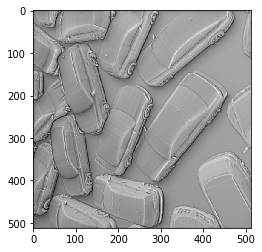

In [37]:
image = torch.cat((pos, normal), 1)
model.eval()
i = model(image)
pic = i.squeeze(1).cpu().data[0].numpy()
plt.imshow(pic, cmap='gray')

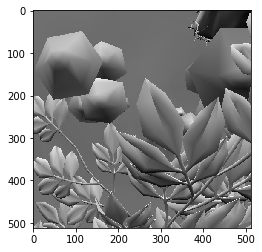

In [13]:
pic = normal[:,1,:,:].cpu().data[0].numpy()
plt.imshow(pic, cmap='gray')

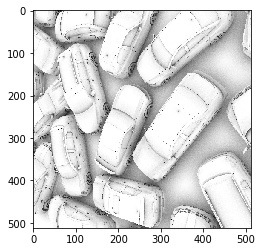

In [38]:
pic = gt.squeeze(1).cpu().data[0].numpy()
plt.imshow(pic, cmap='gray')

In [18]:
pic = exr_loader("./Position/000000000..exr", ndim=3)

D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [7]:
from torchsummary import summary
print(image.size())
summary(model, (6,512,512))

torch.Size([8, 6, 512, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]             440
         LeakyReLU-2          [-1, 8, 512, 512]               0
         AvgPool2d-3          [-1, 8, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]             592
         LeakyReLU-5         [-1, 16, 256, 256]               0
         AvgPool2d-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           1,184
         LeakyReLU-8         [-1, 32, 128, 128]               0
         AvgPool2d-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]           2,368
        LeakyReLU-11           [-1, 64, 64, 64]               0
        AvgPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]           4,736
        Le

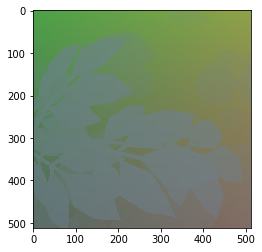

In [19]:
plt.imshow(pic)

In [24]:
# task = "AO", "GI",...
# buffers = a list of "position", "normal", "groundtruth",...
def load_train(task, buffers=None):
    result = {}
    if task == "AO":
        if buffers is None:
            buffers = ["position", "normal", "groundtruth"]
        for buffer_type in buffers:
            result[buffer_type] = load_one_file("./dataset/training_" + buffer_type + ".txt")
    return result

In [28]:
def load_one_file(filename):
    with open(filename) as f:
        images = []
        for line in f.readlines():
            path = line.split()[0]
            images.append(exr_loader(path, ndim=3)) # really 3 ??
    return np.array(images)

In [31]:
data = load_train("AO", ["groundtruth"])

D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [46]:
%cd D:\Dropbox (GaTech)\CS7643 Deep Learning\DL4CG

D:\Dropbox (GaTech)\CS7643 Deep Learning\DL4CG


In [62]:
import OpenEXR
import Imath

# read image and its dataWindow to obtain its size
pic = OpenEXR.InputFile("./GI/Conference/Normals/000000000..exr")
pic.header()

{'channels': {'A': HALF (1, 1),
  'B': HALF (1, 1),
  'G': HALF (1, 1),
  'R': HALF (1, 1)},
 'compression': NO_COMPRESSION,
 'dataWindow': (0, 0) - (255, 255),
 'displayWindow': (0, 0) - (255, 255),
 'lineOrder': INCREASING_Y,
 'pixelAspectRatio': 1.0,
 'screenWindowCenter': (0.0, 0.0),
 'screenWindowWidth': 1.0}

In [67]:
# read image and its dataWindow to obtain its size
pic = OpenEXR.InputFile("./IBL/Conference/Specular/000000000..exr")
print(pic.header())

pt = Imath.PixelType(Imath.PixelType.FLOAT)
dw = pic.header()['dataWindow']
size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

pt = Imath.PixelType(Imath.PixelType.FLOAT)

channel = np.fromstring(pic.channel('B', pt), dtype=np.float32)
channel.shape = (size[1], size[0])  # Numpy arrays are (row, col)
np.array(channel)

{'channels': {'A': HALF (1, 1), 'B': HALF (1, 1), 'G': HALF (1, 1), 'R': HALF (1, 1)}, 'compression': NO_COMPRESSION, 'dataWindow': (0, 0) - (255, 255), 'displayWindow': (0, 0) - (255, 255), 'lineOrder': INCREASING_Y, 'pixelAspectRatio': 1.0, 'screenWindowCenter': (0.0, 0.0), 'screenWindowWidth': 1.0}


D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


array([[0.3046875 , 0.3046875 , 0.3046875 , ..., 0.3046875 , 0.3046875 ,
        0.3046875 ],
       [0.3046875 , 0.3046875 , 0.3046875 , ..., 0.3046875 , 0.3046875 ,
        0.3046875 ],
       [0.3046875 , 0.3046875 , 0.3046875 , ..., 0.3046875 , 0.3046875 ,
        0.3046875 ],
       ...,
       [0.11938477, 0.11938477, 0.11938477, ..., 0.5444336 , 0.5444336 ,
        0.5444336 ],
       [0.11938477, 0.11938477, 0.11938477, ..., 0.5444336 , 0.5444336 ,
        0.5444336 ],
       [0.11938477, 0.11938477, 0.11938477, ..., 0.5444336 , 0.5444336 ,
        0.5444336 ]], dtype=float32)

D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


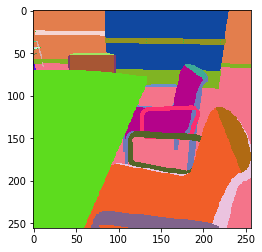

In [70]:
pic = exr_loader("./IBL/Conference/Specular/000000000..exr", ndim=3)
plt.imshow(pic)